# MODULE 2 Assignment
## Haley Schmidt

DOI: 10.24381/cds.adbb2d47

Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47 (Accessed on 09-26-2025)

# Part 1

In [ ]:
# setup
import dask
from dask.distributed import Client

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# configure dask
client = Client()  
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49493/status,
Dashboard: http://127.0.0.1:49493/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49494,Workers: 0
Dashboard: http://127.0.0.1:49493/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:49506,Total threads: 2
Dashboard: http://127.0.0.1:49510/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:49497,


2025-09-27 11:24:58,146 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:49493', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/Users/Haley/atms523/module-2-xarray-dask-and-the-cloud-heschmidt/.venv/lib/python3.10/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/Users/Haley/atms523/module-2-xarray-dask-and-the-cloud-heschmidt/.venv/lib/python3.10/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
  File "/Users/Haley/atms523/module-2-xarray-dask-and-the-cloud-heschmidt/.venv/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if necessary")
bokeh.protocol.except

In [220]:
city = {"name": "Minneapolis", "lat": 44.9778, "lon": -93.2650}

data_glob = "era5_tp.grib"
var_name  = "tp"   # ERA5 total precipitation (meters)

OUT_POINT_CSV = f"{city['name'].replace(',','').replace(' ','_')}_daily_precip_timeseries.csv"
OUT_BOX_NC    = f"{city['name'].replace(',','').replace(' ','_')}_5x5_box_daily_precip.nc"


In [221]:
# Open w/ dask chunking
chunks = {"time": 24 * 31, "latitude": 200, "longitude": 200}

# Open GRIB (was unable to download data as NetCDF)
ds = xr.open_mfdataset(
    data_glob,                        
    engine="cfgrib",                  
    combine="by_coords",
    chunks=chunks,
    parallel=False,                   
    backend_kwargs={"filter_by_keys": {"shortName": "tp"}},
)

In [222]:
# rename and sort data
ds = ds.rename({"latitude": "lat", "longitude": "lon"})
ds = ds.sortby("lat")
ds = ds.assign_coords(lon=((ds["lon"] + 180) % 360) - 180).sortby("lon")

In [223]:
# calculate daily totals in mm/day
da = (ds[var_name] * 1000.0)  

if "step" in da.dims:
    da_last = da.sortby("step").isel(step=-1)
    valid_time = ds["time"] + ds["step"].isel(step=-1)
    da_last = da_last.assign_coords(time=valid_time)
    pr_daily = da_last.resample(time="1D").sum().rename("pr_daily_mm")
else:
    pr_daily = da.resample(time="1D").sum().rename("pr_daily_mm")

pr_daily = pr_daily.clip(min=0)
pr_daily.attrs["units"] = "mm/day"

In [224]:
# Find nearest grid to Minneapolis
pt_series = pr_daily.sel(lat=city["lat"], lon=city["lon"], method="nearest").squeeze(drop=True)
nearest_lat = float(pt_series["lat"])
nearest_lon = float(pt_series["lon"])
print(f"Nearest ERA5 grid to {city['name']}: lat={nearest_lat:.3f}, lon={nearest_lon:.3f}")

# Build 5x5 box 
lat_min, lat_max = nearest_lat - 2.5, nearest_lat + 2.5
lon_min, lon_max = nearest_lon - 2.5, nearest_lon + 2.5

box = pr_daily.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

Nearest ERA5 grid to Minneapolis: lat=45.000, lon=-93.250


In [225]:
# save data

# time series
pt_df = pt_series.to_series()
pt_df.name = "precip_mm_day"
pt_df.to_csv(OUT_POINT_CSV)
print(f"Saved daily point series → {OUT_POINT_CSV}")

# box
box_ds = box.to_dataset(name="pr_daily_mm")
box_ds = box_ds.assign_attrs({
    "city": city["name"],
    "nearest_grid_lat": nearest_lat,
    "nearest_grid_lon": nearest_lon,
    "units": "mm/day",
    "description": "ERA5 daily total precipitation over 5x5 box centered on nearest grid to city",
})
box_ds.to_netcdf(OUT_BOX_NC)
print(f"Saved 5x5 box dataset → {OUT_BOX_NC}")


Saved daily point series → Minneapolis_daily_precip_timeseries.csv
Saved 5x5 box dataset → Minneapolis_5x5_box_daily_precip.nc


# Part 2

In [226]:
# setup 
city = {"name": "Minneapolis"}
OUT_POINT_CSV = f"{city['name'].replace(',','').replace(' ','_')}_daily_precip_timeseries.csv"
s = pd.read_csv(OUT_POINT_CSV, index_col=0, parse_dates=True)["precip_mm_day"]
s.name = "precip_mm_day"

In [227]:
# clean data
x = pd.to_numeric(s, errors="coerce").dropna().values  

In [228]:
# 95th percentile (including 0s)
p95 = np.nanpercentile(x, 95)

In [229]:
# empirical CDF
x_sorted = np.sort(x)
cdf = np.arange(1, n + 1) / n

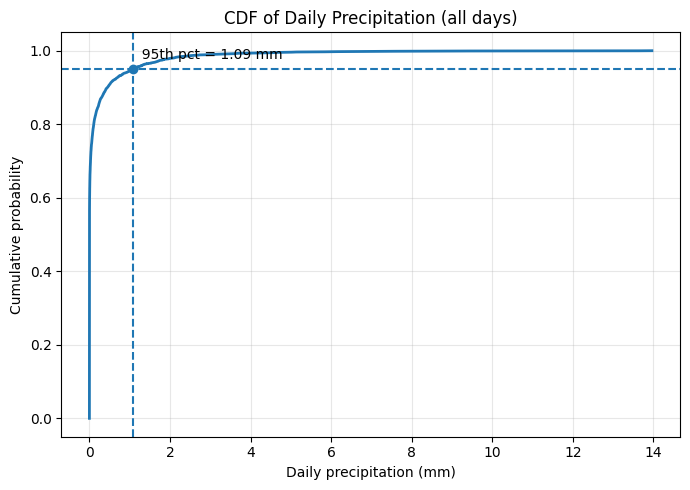

95th percentile (all days): 1.09 mm


In [230]:
# Plot
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_sorted, cdf, lw=2)
ax.axvline(p95, linestyle="--")
ax.axhline(0.95, linestyle="--")
ax.scatter([p95], [0.95], zorder=3)
ax.set_xlabel("Daily precipitation (mm)")
ax.set_ylabel("Cumulative probability")
ax.set_title("CDF of Daily Precipitation (all days)")
ax.grid(True, alpha=0.3)
ax.text(p95, 0.02 + 0.95, f"  95th pct = {p95:.2f} mm", va="bottom")

plt.tight_layout()
plt.show()

print(f"95th percentile (all days): {p95:.2f} mm")


95th percentile (wet days > 0.1 mm): 3.08 mm


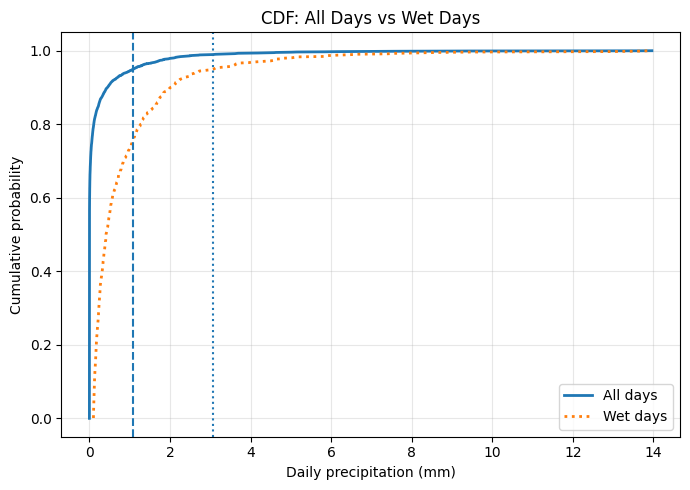

95th percentile (all days): 1.09 mm
95th percentile (wet days): 3.08 mm


In [231]:
# plot only days with precipitation
wet_threshold_mm = 0.1  
x_wet = x[x > wet_threshold_mm]
p95_wet = np.nanpercentile(x_wet, 95)

print(f"95th percentile (wet days > {wet_threshold_mm} mm): {p95_wet:.2f} mm")

xw_sorted = np.sort(x_wet)
cdf_w = np.arange(1, x_wet.size + 1) / x_wet.size

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_sorted, cdf, lw=2, label="All days")
ax.plot(xw_sorted, cdf_w, lw=2, linestyle=":", label="Wet days")
ax.axvline(p95, linestyle="--")
ax.axvline(p95_wet, linestyle=":")
ax.set_xlabel("Daily precipitation (mm)")
ax.set_ylabel("Cumulative probability")
ax.set_title("CDF: All Days vs Wet Days")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# print percentiles for all days vs wet days
print(f"95th percentile (all days): {p95:.2f} mm")
print(f"95th percentile (wet days): {p95_wet:.2f} mm")


# Part 3

In [232]:
# load cartopy to avoid SSL errors
import os
try:
    import certifi
    os.environ.setdefault("SSL_CERT_FILE", certifi.where())
    os.environ.setdefault("REQUESTS_CA_BUNDLE", certifi.where())
except Exception:
    pass  

import cartopy
cartopy.config['data_dir'] = os.path.expanduser("~/.cartopy_cache")
os.makedirs(cartopy.config['data_dir'], exist_ok=True)

In [233]:
# setup
city = {"name": "Minneapolis", "lat": 44.9778, "lon": -93.2650}
var_name = "tp"  
data_glob= "era5_tp.grib"  
POINT_CSV = f"{city['name'].replace(',','').replace(' ','_')}_daily_precip_timeseries.csv"
monthly_baseline_file = "ERA_5_total_precipitation_monthly_1981_2020.nc"

In [234]:
# 40x40 map window
lat_min_us, lat_max_us = 25.0, 50.0
lon_min_us, lon_max_us = -125.0, -66.0

lat0, lon0 = city["lat"], city["lon"]
lat_min, lat_max = lat0 - 20.0, lat0 + 20.0
lon_min, lon_max = lon0 - 20.0, lon0 + 20.0


In [235]:
# fixed color scales 
comp_max = 5.0    
anom_max = 2.0 

In [236]:
# Helper functions

# select lat/lon box regardless of order
def sel_latlon_adaptive(da, lat_min, lat_max, lon_min, lon_max):
    if "lat" not in da.coords or "lon" not in da.coords:
        raise ValueError("No lat/lon coords")
    lat_vals = da["lat"].values
    lat_slice = slice(lat_min, lat_max) if lat_vals[0] < lat_vals[-1] else slice(lat_max, lat_min)
    return da.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# open era5 grib and calculate daily totals (same as part 1)
def build_pr_daily(data_glob, var_name):
    chunks = {"time": 24 * 31, "latitude": 200, "longitude": 200}
    ds = xr.open_mfdataset(
        data_glob,
        engine="cfgrib",
        combine="by_coords",
        chunks=chunks,
        backend_kwargs={"filter_by_keys": {"shortName": var_name}},
    )
    ds = ds.rename({"latitude": "lat", "longitude": "lon"}).sortby("lat")
    ds = ds.assign_coords(lon=((ds["lon"] + 180) % 360) - 180).sortby("lon")
    da = ds[var_name] * 1000.0  
    if "step" in da.dims:
        da_last = da.sortby("step").isel(step=-1)
        valid_time = ds["time"] + ds["step"].isel(step=-1)
        da_last = da_last.assign_coords(time=valid_time)
        pr_daily = da_last.resample(time="1D").sum()
    else:
        pr_daily = da.resample(time="1D").sum()
    pr_daily = pr_daily.clip(min=0).rename("pr_daily_mm")
    pr_daily.attrs["units"] = "mm/day"
    return pr_daily

In [237]:
# load 95 percentile dates
s = pd.read_csv(POINT_CSV, index_col=0, parse_dates=True)["precip_mm_day"]
s = pd.to_numeric(s, errors="coerce").dropna()
p95_all = np.nanpercentile(s.values, 95)
exceed_dates = s.index[s.values >= p95_all]
months_used = np.unique(pd.DatetimeIndex(exceed_dates).month)
print(f"P95: {p95_all:.2f} mm/day --- n≥P95 days: {len(exceed_dates)}")


P95: 1.09 mm/day --- n≥P95 days: 201


In [238]:
# Daily composites of the US
try:
    pr_daily  
except NameError:
    pr_daily = build_pr_daily(data_glob, var_name)

# Subset to entire US
# select ≥P95 dates and average
pr_us = sel_latlon_adaptive(pr_daily, lat_min_us, lat_max_us, lon_min_us, lon_max_us)
region_on95_us = pr_us.sel(time=np.array(exceed_dates, dtype="datetime64[ns]")).load()
composite_on95_us = region_on95_us.mean("time").rename("composite_on95_mm_day")


In [239]:
# open monthly baseline 1981–2010 data
mbase = xr.open_dataset(monthly_baseline_file)

# Standardize coords and time
rename_map = {}
if "latitude" in mbase.coords:  rename_map["latitude"]  = "lat"
if "longitude" in mbase.coords: rename_map["longitude"] = "lon"
mbase = mbase.rename(rename_map)
if "valid_time" in mbase.coords and "time" not in mbase.coords:
    mbase = mbase.rename({"valid_time": "time"})
if "lon" in mbase.coords:
    mbase = mbase.assign_coords(lon=((mbase["lon"] + 180) % 360) - 180).sortby("lon")
if "lat" in mbase.coords:
    mbase = mbase.sortby("lat")  

# 1981–2010 slice
mbase_8110 = mbase.sel(time=slice("1981-01-01", "2010-12-31"))

# select precip variable
var_m = var_name if var_name in mbase_8110.data_vars else list(mbase_8110.data_vars)[0]

# convert units
units = str(mbase_8110[var_m].attrs.get("units", "")).lower()
tp_mm = mbase_8110[var_m] * (1000.0 if ("mm" not in units and "m" in units) else 1.0)
tp_mm_day = (tp_mm / mbase_8110["time"].dt.days_in_month).rename("tp_mm_day")

# US region 
tp_reg_us = sel_latlon_adaptive(tp_mm_day, lat_min_us, lat_max_us, lon_min_us, lon_max_us)

tp_reg_used_us = tp_reg_us.where(tp_reg_us["time"].dt.month.isin(months_used), drop=True)
if tp_reg_used_us.sizes.get("time", 0) == 0:
    raise ValueError("No baseline months found matching months_used within 1981–2010.")
baseline_us = (
    tp_reg_used_us.groupby("time.month").mean("time").mean("month")
).rename("baseline_mm_day")

In [240]:
# regrid baseline to composite grid
baseline_us_on_comp = baseline_us.interp(
    lat=composite_on95_us["lat"], lon=composite_on95_us["lon"], method="linear"
)

#compute anomaly
anomaly_us = (composite_on95_us - baseline_us_on_comp).rename("anomaly_mm_day")

In [241]:
# crop to 40×40 window
composite_on95 = sel_latlon_adaptive(composite_on95_us, lat_min, lat_max, lon_min, lon_max)
anomaly        = sel_latlon_adaptive(anomaly_us,        lat_min, lat_max, lon_min, lon_max)

# check shapes
print("composite:", composite_on95.shape, "baseline:", baseline_us_on_comp.shape, "anomaly:", anomaly.shape)

composite: (21, 21) baseline: (21, 21) anomaly: (21, 21)


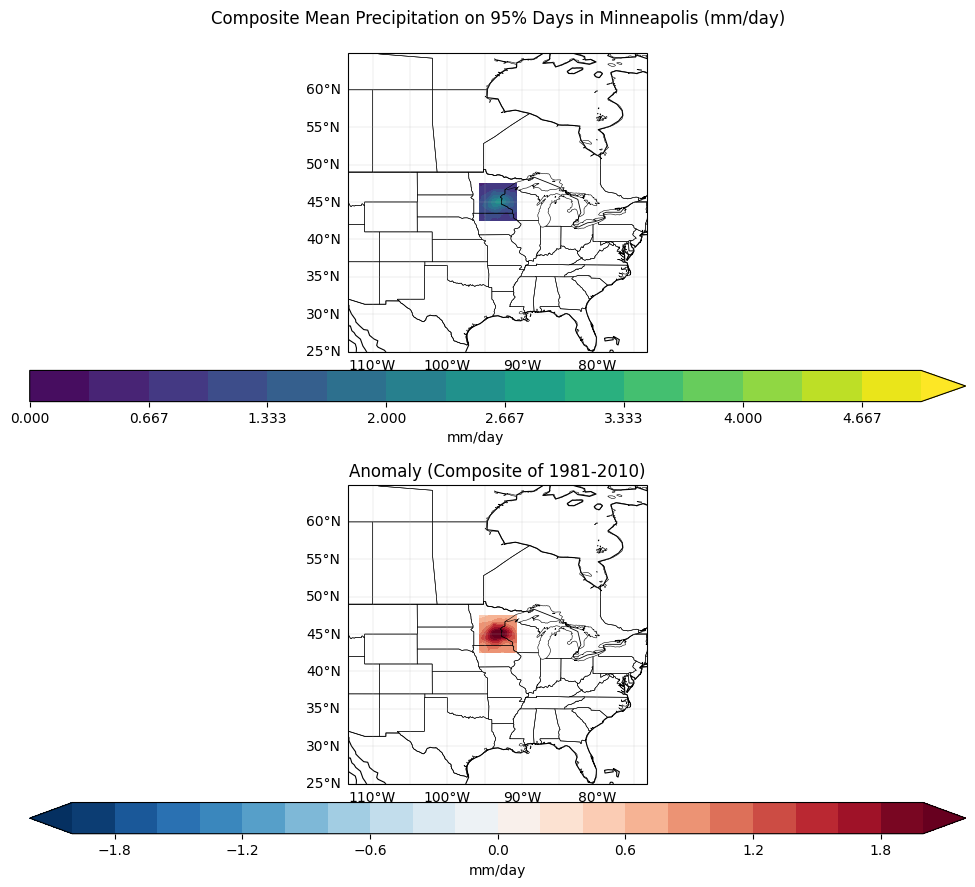

In [242]:
# Plot

proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]

fig = plt.figure(figsize=(12, 9))

# Plot Composite map
ax1 = plt.subplot(2, 1, 1, projection=proj)
im1 = ax1.contourf(composite_on95["lon"], composite_on95["lat"], composite_on95,
                   levels=np.linspace(0, comp_max, 16), transform=proj, extend="max")
ax1.set_extent(extent, crs=proj)
ax1.coastlines(resolution="110m", linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.6)
ax1.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.4, edgecolor="black")
gl = ax1.gridlines(crs=proj, draw_labels=True, x_inline=False, y_inline=False,
                    linewidth=0.3, alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax1.set_title(
    f"Composite Mean Precipitation on 95% Days in Minneapolis (mm/day)\n")
cbar1 = plt.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05, shrink=0.8, aspect=30)
cbar1.set_label("mm/day")

# Plot anomaly map
ax2 = plt.subplot(2, 1, 2, projection=proj)
im2 = ax2.contourf(anomaly["lon"], anomaly["lat"], anomaly,
                   levels=np.linspace(-anom_max, anom_max, 21),
                   cmap="RdBu_r", transform=proj, extend="both")
ax2.set_extent(extent, crs=proj)
ax2.coastlines(resolution="110m", linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.6)
ax2.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.4, edgecolor="black")
gl = ax2.gridlines(crs=proj, draw_labels=True, x_inline=False, y_inline=False,
                    linewidth=0.3, alpha=0.5)
gl.right_labels = False
gl.top_labels = False

used_months_str = ", ".join(map(str, months_used))
ax2.set_title(f"Anomaly (Composite of 1981-2010)")
cbar2 = plt.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.05, shrink=0.8, aspect=30)
cbar2.set_label("mm/day")

plt.tight_layout()
plt.show()

## Note: The same code was previously cropping to the correct extent and I cant seem to find the root of the issue

In [243]:
# Save
out_nc = f"{city['name'].replace(',','').replace(' ','_')}_US_composite_anomaly_40x40.nc"
xr.merge([composite_on95_us, baseline_us_on_comp, anomaly_us]).to_netcdf(out_nc)
print(f"Saved composites/anomaly (US grids) → {out_nc}")

Saved composites/anomaly (US grids) → Minneapolis_US_composite_anomaly_40x40.nc


In [244]:
Client.close

<function distributed.client.Client.close(self, timeout=<no_default>)>